In [14]:
import pandas as pd
import spacy
import seaborn as sns
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [15]:
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner','textcat'])

c:\Users\Naim\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [16]:
negation_list = ['not',
'no',
'don',
'don\'t',
'ain',
'aren',
'aren\'t',
'couldn',
'couldn\'t',
'didn',
'didn\'t',
'doesn',
'doesn\'t',
'hadn',
'hadn\'t',
'hasn',
'hasn\'t',
'haven',
'haven\'t',
'isn',
'isn\'t',
'mightn',
'mightn\'t',
'mustn',
'mustn\'t',
'needn',
'needn\'t',
'shan',
'shan\'t',
'shouldn',
'shouldn\'t',
'wasn',
'wasn\'t',
'weren',
'weren\'t',
'won',
'won\'t',
'wouldn',
'wouldn\'t']

In [17]:
for i in negation_list:
    nlp.vocab[i].is_stop = False

In [18]:
df=pd.read_csv("LatestData.csv")
df.head()

,id,text,class,sentiment,label
0,1,It was an overall good experience. The waiting...,NaN,NaN,1Positive#Staff
1,2,Been there recently. Long queue as the clinic ...,NaN,NaN,1Negative#Appointments#Staff
2,3,If this is not your panel clinic so that you c...,NaN,NaN,1Negative#Appointments#Staff
3,4,Waited for more than 2 hours just to vist a do...,NaN,NaN,1Negative#Appointments#Staff#Treatment
4,5,nearby to setapak central\r\nwith other shoplo...,NaN,NaN,1Positive#Facilities#Staff


In [19]:
def clean_text(text):
    text = text.lower()
    doc = nlp(text)
    
    text = ' '.join(token.lemma_ for token in doc if
              not token.is_punct
              and not token.is_currency
              and not token.is_digit
              and not token.is_space
              and not token.is_stop
                   )
    return text

In [20]:
df['text'] = df['text'].apply(lambda x:clean_text(x))

In [21]:
dummies=df["label"].str.get_dummies("#")
df=pd.concat([df,dummies],axis=1)
df.loc[df["1Positive"]==1,"sentiment"]=1
df.loc[df["1Positive"]==0,"sentiment"]=0

In [22]:
dummies = dummies.drop(['1Positive', '1Negative'], axis = 1)

In [23]:
label = list(dummies.columns)
y = dummies.to_dict('index')

In [24]:
dataset = list(zip(df['text'],[{'cats': cats} for cats in y.values()]))
print(dataset[0])
train_data, test_data = train_test_split(dataset, train_size=0.8, random_state=13)

('overall good experience wait time long queue okay like dr hanifah doctor listen try understand go thank doc close setapak sentral incase need buy check columbia hospital incase need hospital referral lot food option', {'cats': {'Appointments': 0, 'Facilities': 0, 'Staff': 1, 'Treatment': 0}})


In [25]:
nlp_model = spacy.load("./output/model-best/")

In [26]:
def evaluate_model(model, data, threshold=0.5):

    total_tp = 0
    total_fp = 0
    total_tn = 0
    total_fn = 0

    for doc, label in tqdm(nlp_model.pipe(test_data, as_tuples=True)):
        target = np.array(list(label['cats'].values()))
        pred = np.array(list(doc.cats.values()))

        pred[pred > threshold] = 1
        pred[pred < threshold] = 0

        for idx in range(pred.shape[0]):
            # True positive
            if target[idx] == 1 and target[idx] == pred[idx]:
                total_tp += 1
            # True negative
            elif target[idx] == 0 and target[idx] == pred[idx]:
                total_tn += 1
            # False negative, supposed to be 1 but predicted 0
            elif target[idx] == 1 and target[idx] != pred[idx]:
                total_fn += 1
            # False positive, supposed to be 0 but predicted 1
            elif target[idx] == 0 and target[idx] != pred[idx]:
                total_fp += 1

    return total_tp, total_tn, total_fp, total_fn

tp, tn, fp, fn = evaluate_model(nlp_model, test_data)

275it [00:00, 911.93it/s]


In [27]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

precision_vals = []
recall_vals = []
fpr_vals = []
accuracies = []

for threshold in thresholds:
    tp, tn, fp, fn = evaluate_model(nlp_model, test_data, threshold)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fpr = fp / (fp + tn)

    accuracy = (tp + tn) / (tp + tn + fn + fp)
    accuracies.append(round(accuracy, 2))

    precision_vals.append(precision)
    recall_vals.append(recall)
    fpr_vals.append(fpr)

275it [00:00, 1211.44it/s]
275it [00:00, 1278.35it/s]
275it [00:00, 1303.33it/s]
275it [00:00, 1155.01it/s]
275it [00:00, 941.79it/s]
275it [00:00, 843.55it/s]
275it [00:00, 859.39it/s]
275it [00:00, 992.80it/s]
275it [00:00, 1315.83it/s]


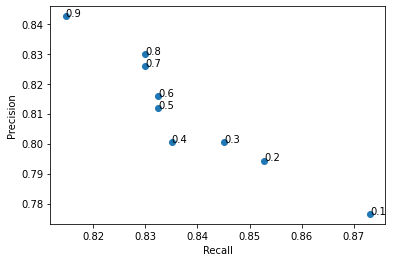

In [28]:
plt.plot(recall_vals, precision_vals, 'o')
for i, (x, y) in enumerate(zip(recall_vals, precision_vals)):
    plt.annotate(str(thresholds[i]), (x,y))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

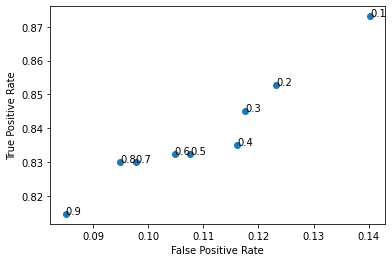

In [29]:
plt.plot(fpr_vals, recall_vals, 'o')
for i, (x, y) in enumerate(zip(fpr_vals, recall_vals)):
    plt.annotate(str(thresholds[i]), (x,y))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [30]:
print(accuracies)

[0.86, 0.87, 0.87, 0.87, 0.87, 0.87, 0.88, 0.88, 0.88]


In [31]:
print(thresholds)
print(precision_vals)
print(recall_vals)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[0.7765237020316027, 0.7943262411347518, 0.8004807692307693, 0.8004866180048662, 0.8118811881188119, 0.8159203980099502, 0.8257575757575758, 0.8299492385786802, 0.84251968503937]
[0.8730964467005076, 0.8527918781725888, 0.8451776649746193, 0.8350253807106599, 0.8324873096446701, 0.8324873096446701, 0.8299492385786802, 0.8299492385786802, 0.8147208121827412]
